<a href="https://colab.research.google.com/github/dve2/Heights/blob/main/notebooks/inference_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Example of working inference (one file only)
#Creating folders "Images" and "Masks"
import os
new_dir1 = "Images"
new_dir2 = "Masks"
os.mkdir(new_dir1)
os.mkdir(new_dir2)

Inference

In [2]:
#Loading weights:
!wget https://github.com/dve2/Heights/raw/refs/heads/main/weights/epoch=931-step=11184.ckpt

#filename for inference:
ffi = "2017.03.30 CP MPO.022_1024.txt"

#Loading image for inference and placing it to the folder "Images":
!wget https://github.com/dve2/Heights/raw/refs/heads/main/tests/data/Images/2017.03.30%20CP%20MPO.022_1024.txt
os.rename(ffi, os.path.join("Images",ffi))

#Loading dotted mask and placing it to the folder "Masks"
!wget https://github.com/dve2/Heights/raw/refs/heads/main/tests/data/Masks/_2017.03.30%20CP%20MPO.022_1024.txt
os.rename(f"_{ffi}", os.path.join("Masks",f"_{ffi}"))

--2024-11-21 10:36:09--  https://github.com/dve2/Heights/raw/refs/heads/main/weights/epoch=931-step=11184.ckpt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dve2/Heights/refs/heads/main/weights/epoch%3D931-step%3D11184.ckpt [following]
--2024-11-21 10:36:10--  https://raw.githubusercontent.com/dve2/Heights/refs/heads/main/weights/epoch%3D931-step%3D11184.ckpt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72398304 (69M) [application/octet-stream]
Saving to: ‘epoch=931-step=11184.ckpt’

epoch=931-step=1118 100%[===================>]  69.04M   144MB/s    in 0.5s    

2024-11-21 10:36:11 (144 MB

In [3]:
!pip install segmentation-models-pytorch lightning torchmetrics

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 26.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=7af7aad844283ece509541529d588456c01e9c6634032ce5fca9bb32b4492197
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3

In [4]:
from math import nan
from torch.utils.data import Dataset
from glob import glob
import os
from pathlib import Path
import torch
import pandas as pd
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
import warnings
import ast
#from torchvision import tv_tensors
import pickle
import torchvision.transforms.functional as F
from statistics import mode


from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from torchvision.transforms import ToTensor

def load_cache(filename = "cachedm.pickle"):
      if os.path.isfile(filename):
        with open(filename, 'rb') as f:
           cache =  pickle.load(f)
        print(f"Loaded cache from {filename}")
        return cache
      return None
cache = load_cache()

class CustomDataset2chdm(Dataset):
    def __init__(self, root_dir, transform=None, target_transform = None, exclude = [], cache = None):
      images = glob(f"{root_dir}{os.sep}Images{os.sep}*")
      labels = glob(f"{root_dir}{os.sep}Masks{os.sep}_*") # read only continuous heigths
      # extract id from paths
      im = set(map(lambda x: Path(x).stem,images))
      lab = set(map(lambda x: Path(x).stem[1:],labels))
      img_without_masks = im - lab
      if len(img_without_masks) > 0:
        warn_text = f"Found images without masks {','.join(img_without_masks)}"
        warnings.warn(warn_text)
      self.items =  (list((im & lab) - set(exclude)))
      self.items.sort()
      self.root_dir = root_dir
      self.transform = transform
      self.target_transform = target_transform
      self.max_height = 100
      if cache == None:
          self.cache = {}
      else:
        self.cache = cache

      #self.load_cache()
      #self.scales = self.get_all_scales()

    def get_all_scales(self):
        scales = []
        for name in self.items:
            path = self.get_im_path(name)
            image, real_w = self.txt2pil(path)
            scales.append(self.get_scale(image, real_w))
        return np.array(scales)

    def get_scale(self, img, real_w):
      return  real_w / img.shape[1]   #  micron per pixel; "[0]" changed to "[1]"

    def get_im_path(self,name):
      path = f"{self.root_dir}{os.sep}Images{os.sep}{name}.txt"
      return path

    def get_mask_path(self,name):
      path = f"{self.root_dir}{os.sep}Masks{os.sep}_{name}.txt"
      return path

    def save_cache(self,filename = "cache.pickle"):
      with open(filename, 'wb') as f:
        pickle.dump(self.cache, f, pickle.HIGHEST_PROTOCOL)

    def load_cache(self,filename = "cache.pickle"):
      if os.path.isfile(filename):
        with open(filename, 'rb') as f:
          self.cache =  pickle.load(f)
        print(f"Loaded cache from {filename}")

    def __len__(self):
      return len(self.items)

    def line2tensor(self,line):
        txt = line.strip()
        parts = txt.split("\t")
        parts = list(filter(len,parts)) #remove empty
        if len(parts) <= 2:
          return None
        numbers = list(map(float, parts))
        t = torch.tensor(numbers)
        return t


    def txt2pil(self, filename):
      if filename in self.cache and "image" in self.cache[filename]:
        return self.cache[filename]["image"].copy(), self.cache[filename]["real_w"]

      # convert list of relative heights to image
      with open(filename, encoding='unicode_escape') as file:
        x_line = file.readline() # X
        x = self.line2tensor(x_line[6:]) # bypass X,nm "8:" was replaced by "5:"
        real_w = (x.max()-x.min()).item() #let it be in microns
        units = x_line[3:5]
        if units == "A°":
          real_w = real_w/10000
        if units == "nm":
          real_w = real_w/1000
        line = file.readline() # Y, Z skip it
        lines = []
        for line in file:
          if line != '\n':  #to exclude the last line
            pos = line.index('\t')#position of the first tabulation
            line2 = line[(pos + 2):]#exclude Y-coordinate and 2 tabulations after it
            t = self.line2tensor(line2)
            if t is not None:
              lines.append(t)
        t = torch.stack(lines)
        # Shift to zero
        # Because all heights just a difference between current and randomly sampled point
        t = t - t.min()
        t = t.numpy()
        self.cache[filename]= {"image": t, "real_w" : real_w}
      return t, real_w

    def get_height_map(self, path):
      if not (path in self.cache and "mask" in self.cache[path]):
          with open(path, 'r') as file:
            content = file.read()
          x = ast.literal_eval(content)
          x = np.array(x)
          self.cache[path] = { "mask" : x }
      return self.cache[path]["mask"].copy()
      #return x


    def __getitem__(self,n):
      """
        img - data(raw heights) from microscope
        masks - continious globules height map

        real_w - width of the image in microns
      """
      name = self.items[n]
      img = self.get_im_path(name)
      mask = self.get_mask_path(name)

      image, real_w = self.txt2pil(img)
      mask = self.get_height_map(mask)

      #image, orig_size, scale_factor = self.rescale(image,real_w)
      #mask, _, _ = self.rescale(mask,real_w)
      scale_factor = 0

      if self.transform:
        output = self.transform(image=image, mask=mask)
        image = output['image']
        mask = output['mask'] # here mask is cropped but not normalized
        if self.target_transform:
          mask = self.target_transform(mask)
      meta = {"w": real_w, 'name' : name, "scale_factor": scale_factor}
      binary_mask = torch.where(mask != 0, 1, 0)
      mask2 = torch.unsqueeze(binary_mask, 0)
      im_mask = torch.cat((image, mask2), 0) #creates two channel tensor, where 1 channel is image, 2nd channel is mask
      return im_mask, image, mask, meta

    def rescale(self,img, real_w):
      resize_coeff = 1
      h,w = img.shape[:2]
      original_size = (h,w)
      #most_popular_scale = mode(self.scales)
      most_popular_scale = 0.00389862060546875
      scale = self.get_scale(img,real_w)
      if most_popular_scale != scale:
        resize_coeff = most_popular_scale/scale
      new_size = tuple((np.array(original_size) / resize_coeff).astype(int).tolist()) # '*' changed to '/'
      img = cv2.resize(img, new_size)
      return img, original_size, resize_coeff

In [5]:
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
mean, std = [8.489298], [9.06547]

train_transforms = A.Compose(
    [
        A.Normalize(mean, std),
        A.RandomCrop(192, 192),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Normalize(mean, std),
        A.CenterCrop(192, 192),
        ToTensorV2(),
    ]
)

class NormalizeNonZero(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, x):
        mask = x == 0
        x -= self.mean
        x /= self.std
        x[mask] = 0
        return x.to(torch.float32)

    def denorm(self,x):
        mask = x == 0
        x *=  self.std
        x += self.mean
        x[mask] = 0
        return x

dot_target_mean, dot_target_std = 3.016509424749255, 2.452459479074767
nnz = NormalizeNonZero(dot_target_mean, dot_target_std)

target_transform = T.Compose([nnz])

In [7]:
import os
import pickle
%load_ext autoreload
%autoreload 2

from math import nan
from torch.utils.data import Dataset
from glob import glob
import os
from pathlib import Path
import torch
import pandas as pd
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
import warnings
import ast
#from torchvision import tv_tensors
import pickle
import torchvision.transforms.functional as F
from statistics import mode


from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from torchvision.transforms import ToTensor

In [8]:
ds_test = CustomDataset2chdm("/content", transform  = val_transforms, target_transform=target_transform, cache = cache)
loader_test = DataLoader(ds_test, batch_size=4, shuffle=False, num_workers=2)
#ds_test = CustomDataset("Splitted Dataset/Test")

In [9]:
from torchmetrics import MeanSquaredError
from typing import Any, Optional, Sequence, Union
from torch import Tensor

class ZeroAwareMSE(MeanSquaredError):
    def update(self, preds: Tensor, target: Tensor) -> None:
        target_sum = torch.sum(target).item()
        if target_sum == 0:#change preds and targets in such a way that the result would be zero tensor (not works directly)
            preds = preds - preds + 1
            target = target + 1
        mask = target != 0
        return super().update(preds[mask],target[mask])


In [10]:
def MSELoss_mask(pred, target): #MSE loss calculated only inside the masks (which are contained in the targets)
  mse_loss = MSELoss(reduction='sum')  #calculates sum of the squared errors (without division by n)
  loss = mse_loss(pred, target) #calculates sum of the squared errors (without division by n)
  target_binary = torch.where(target != 0, 1, 0) #writing 1 in each unmasked pixel and 0 in each masked pixel (for calculation the number of unmasked pixels)
  n_ummasked_pxls = target_binary.sum()#.item() #calculating the number of unmasked pixels
  if n_ummasked_pxls == 0:
    return 0

  return loss/n_ummasked_pxls

import torch.nn as nn

class CustomLoss(nn.Module):
  def __init__(self):
    super(CustomLoss, self).__init__()

  def forward(self, pred, target):
    return MSELoss_mask(pred, target)

In [11]:
import lightning as L
from torchmetrics import MeanSquaredError
from torch.nn import MSELoss
import torch

class Lit(L.LightningModule):
    def __init__(self, model, lr=0.0025):
        super().__init__()
        self.model = model
        self.lr = lr
        self.criterion = CustomLoss()
        self.save_hyperparameters()
        self.metric_train = ZeroAwareMSE()
        self.metric_train_dn = ZeroAwareMSE()
        self.metric_val = ZeroAwareMSE()
        self.metric_val_dn = ZeroAwareMSE()
        self.metric_test = ZeroAwareMSE()
        self.metric_test_dn = ZeroAwareMSE()  #??

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        _, imgs, masks, meta = batch
        predicted_masks = self.get_prediction(batch)
        #print(predicted_masks, masks)
        loss = self.criterion(predicted_masks, masks)
        #loss_dn = self.criterion(nnz.denorm(predicted_masks), nnz.denorm(masks))
        self.log("Loss/", loss.item(), prog_bar=False)
        #self.log("Loss_dn/", loss_dn.item(), prog_bar=False)
        self.metric_train.update(predicted_masks, masks)
        #self.metric_train_dn.update(nnz.denorm(predicted_masks), nnz.denorm(masks))
        return loss

    def get_prediction(self,batch):
        im_masks, imgs, masks, meta = batch
        predicted_masks = self.model(im_masks).squeeze(1)
        predicted_masks = self.postprocess(predicted_masks, masks)
        return predicted_masks

    def postprocess(self, pred, mask):
        pred = pred.squeeze(1)
        pred[mask == 0] = 0
        return pred

    def validation_step(self, batch, batch_idx):
        _, imgs, masks, meta = batch
        predicted_masks = self.get_prediction(batch)
        self.metric_val.update(predicted_masks, masks)
        self.metric_val_dn.update(nnz.denorm(predicted_masks), nnz.denorm(masks))

    def on_validation_epoch_end(self):
        self.log("MSE/val", self.metric_val.compute(), prog_bar=True)
        self.log("MSE/val_dn", self.metric_val_dn.compute(), prog_bar=True)
        self.metric_val.reset()
        self.metric_val_dn.reset()

    def on_train_epoch_end(self):
        self.log("MSE/train", self.metric_train.compute())
        #self.log("MSE_dn/train", self.metric_train_dn.compute())
        self.metric_train.reset()

    def test_step(self, batch, batch_idx):
        im_masks, imgs, masks, _ = batch
        predicted_masks = self.get_prediction(batch)
        self.log("MSE/test", self.metric_test.compute(), prog_bar=True)
        self.metric_test.update(predicted_masks, masks)
        self.metric_test_dn.update(nnz.denorm(predicted_masks), nnz.denorm(masks))#??

    def on_test_epoch_end(self):
        self.log("MSE/test", self.metric_test.compute(), prog_bar=True)
        self.log("MSE/test_dn", self.metric_test_dn.compute(), prog_bar=True)
        self.metric_test.reset()
        self.metric_test_dn.reset()

In [12]:
import segmentation_models_pytorch as smp

smp_unet = smp.Unet(
    encoder_name="efficientnet-b0",  # choose encoder
    encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=2,  # model input channels 3 for RGB
    classes=1,  # model output channels (number of classes in mask)
)

In [13]:
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='MSE/val',
    #monitor='MSE/train',
    dirpath='lightning_logs',
    #filename='sample-mnist-{epoch:02d}-{val_loss:.2f}',
    save_top_k=5,
    mode='min',
    #every_n_epochs=10
)

#lit_model = Lit(smp_unet)

logger = TensorBoardLogger("lightning_logs", name="SMPUnet")
trainer = L.Trainer(
    max_epochs=1,
    logger=logger,
    log_every_n_steps=5,
    callbacks=[checkpoint_callback]
)  # def on_validation_epoch_start(self):


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [14]:
lit_model1 = Lit.load_from_checkpoint('epoch=931-step=11184.ckpt')
model = lit_model1.model
model.eval()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      2, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [15]:
im_masks, img, mask, meta = ds_test[0]
pred = model(im_masks.unsqueeze(0))
d_pred = nnz.denorm(pred)
d_pred = d_pred.squeeze(0).squeeze(0)
d_pred[mask ==0] =0
d_mask = nnz.denorm(mask)

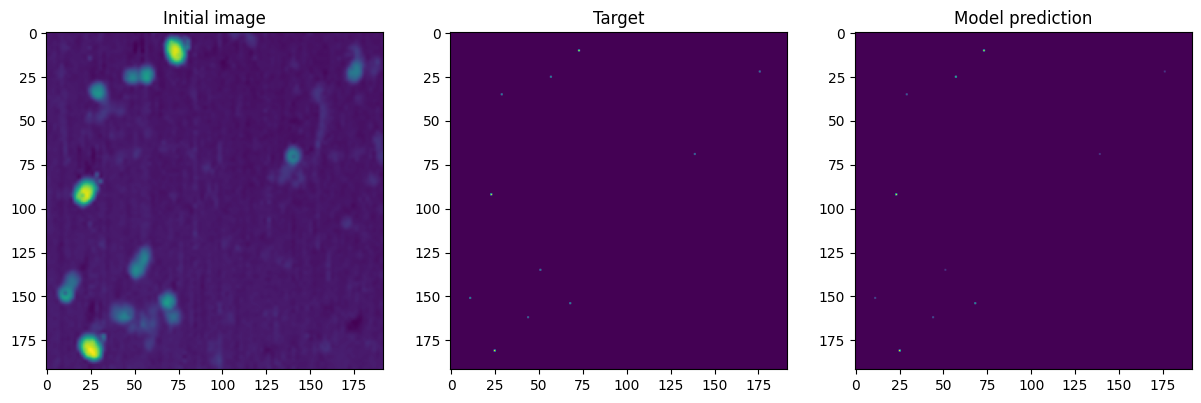

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,7))
ttt1 = img.squeeze(0).detach().cpu().numpy()
plt.subplot(1,4,1)
plt.title('Initial image')
ttt1 = plt.imshow(ttt1)

ttt2 = d_mask.squeeze(0).detach().cpu().numpy()
plt.subplot(1,4,2)
plt.title('Target')
ttt2 = plt.imshow(ttt2)


ttt3 = d_pred.squeeze(0).detach().cpu().numpy()
plt.subplot(1,4,3)
plt.title('Model prediction')
ttt3 = plt.imshow(ttt3)

In [17]:
trainer.test(model=lit_model1, dataloaders=loader_test)

Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric ZeroAwareMSE was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         MSE/test          │    0.09756069630384445    │
│        MSE/test_dn        │    0.5867844223976135     │
└───────────────────────────┴───────────────────────────┘

[{'MSE/test': 0.09756069630384445, 'MSE/test_dn': 0.5867844223976135}]